In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0-dev20211015
GPU detected: []


In [12]:
from pymongo import MongoClient
from bson.objectid import ObjectId
import spacy

db = MongoClient()['scoin2']

def findTokens(doc,manualCodes):
    #print (manualCodes)
    ret = []
    for i,token in enumerate(doc):
        ts = token.idx
        
        te = ts + len(token.text)
        
        codes = []
        for mc in manualCodes:
            ms,me = mc['i0'],mc['i1']
            if aIncludes(ms,me,ts,te):
                codes.append((mc['code'],True))
            elif intersects(ms,me,ts,te):
                codes.append((mc['code'],False))
        #print(token.text,ts,te,codes)
        if len(codes) > 0:
            ret.append((token.text,codes[0][0]))
        else:
            ret.append((token.text,'-'))
    return ret

def mkSamples(items):
    items = list(items)
    chars = {}
    print("Found %i items" % len(items))
    ret = []
    meta = []
    for itm in items:
        oid = itm['_id']
        desc = itm['desc']
        manualCodes = itm['manualCodes']
        
        sample = []
        for i,c in enumerate(desc):
            chars[c] = 1
            codes = []
            for mc in manualCodes:
                if i == mc['i0']:
                    codes.append("B-"+mc['code'])
                elif i > mc['i0'] and i < mc['i1']:
                    codes.append("I-"+mc['code'])
            
            if len(codes) == 0 :
                codes = ['-']
            
            sample.append((c,codes[0]))
            
        ret.append(sample)
        meta.append({'oid':oid})
    return set(chars),ret,meta

def windowsamples(samples,ml,meta):
    ret = []
    newmeta = []
    for si,s in enumerate(samples):
        if len(s) < ml:
            ret.append(s)
            newmeta.append({'oid':meta[si]['oid'],'i':0})
        else:
            for i in range(0,len(s),int(ml/2)):
                tp = s[i:i+ml]
                if len(tp) > ml/2:
                    ret.append(tp)
                    newmeta.append({'oid':meta[si]['oid'],'i':i})
                    
    return ret,newmeta

In [4]:
chars,samples,meta = mkSamples(db.items.find({
    "manualCodes.code" : {"$eq" : "ric"} ,
#    "manualCodes.code" : {"$exists" : True} ,
#    "_id" : ObjectId("56595eda60b26abea2d919f0")
    }))
#chars,samples

tags = sorted({tag for sentence in samples for _, tag in sentence})
tag2idx = {tag: index for index, tag in enumerate(tags)}
word2idx = {w : index for index,w in enumerate(sorted(chars))}
idx2word = {index : w for index,w in enumerate(sorted(chars))}

Found 535 items


In [5]:
num_tags = len(tags)
num_words = len(chars)

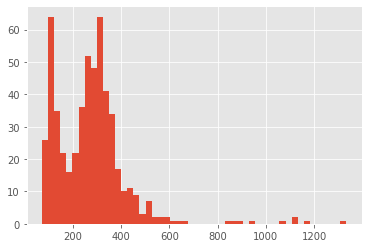

In [10]:
plt.hist([len(s) for s in samples],bins=50);

In [8]:
MAX_LEN = 100

window_samples,window_meta = windowsamples(samples,MAX_LEN,meta)

In [14]:
EMB_DIM = MAX_LEN

from tensorflow.keras.utils import to_categorical

def preprocess(samples):
    X = np.zeros((len(samples), MAX_LEN), dtype=np.float32)
    y = np.zeros((len(samples), MAX_LEN), dtype=np.uint8)
    for i, sentence in enumerate(samples):
        for j, (token, tag) in enumerate(sentence[:MAX_LEN]):
            X[i,j] = word2idx[token]
            y[i,j] = tag2idx[tag]

    y = np.array([ to_categorical(i,num_classes=num_tags) for i in y ]) 
    
    return X, y

X, y = preprocess(window_samples)

In [16]:
X.shape,y.shape

((4, 100), (4, 100, 37))

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)

In [18]:
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Embedding,SpatialDropout1D,Bidirectional,LSTM,TimeDistributed,Dense

input_word = Input(shape=(MAX_LEN,))
model = Embedding(input_dim = num_words,output_dim=MAX_LEN,input_length=MAX_LEN)(input_word)

In [19]:
model = SpatialDropout1D(0.1)(model)

In [20]:
model = Bidirectional(LSTM(units = 100,return_sequences=True,recurrent_dropout=0.1))(model)

In [21]:
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)

In [22]:
model = Model(input_word,out)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          12500     
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 37)          7437      
 ibuted)                                                         
                                                             

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)

In [27]:
! nvidia-smi

Sun Oct 24 20:46:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 165...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0    16W /  N/A |   2866MiB /  3914MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
x_train.shape,y_train.shape

((2413, 100), (2413, 100, 37))

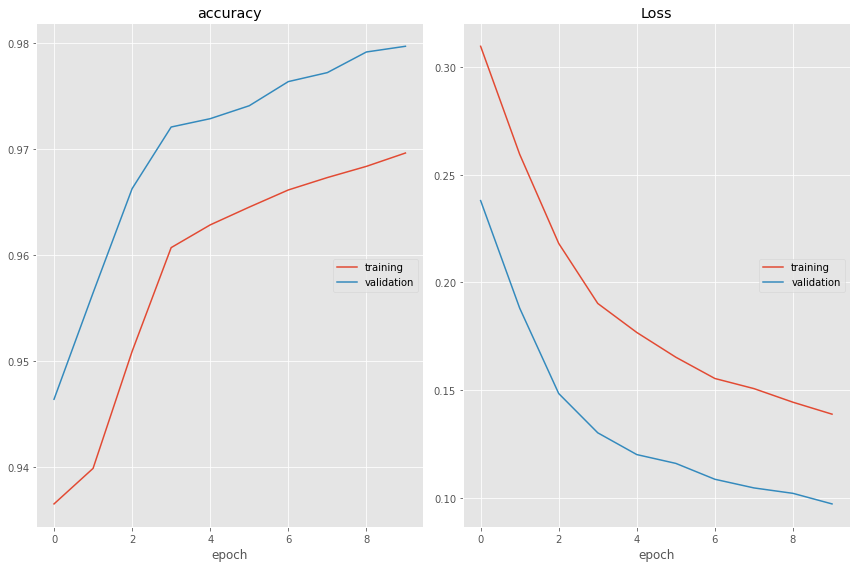

accuracy
	training         	 (min:    0.937, max:    0.970, cur:    0.970)
	validation       	 (min:    0.946, max:    0.980, cur:    0.980)
Loss
	training         	 (min:    0.139, max:    0.310, cur:    0.139)
	validation       	 (min:    0.097, max:    0.238, cur:    0.097)

Epoch 00010: val_loss improved from 0.10205 to 0.09714, saving model to negextractor2.h5
61/61 [==============================] - 27s 444ms/step - loss: 0.1388 - accuracy: 0.9696 - val_loss: 0.0971 - val_accuracy: 0.9797
CPU times: user 7min 28s, sys: 45.1 s, total: 8min 13s
Wall time: 3min 47s


In [31]:
%%time

chkpt = ModelCheckpoint("negextractor2.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt,
            # early_stopping
            ]

history = model.fit(
    x_train,y_train,
    validation_split=0.2,
    batch_size = 32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

In [32]:
model.evaluate(x_test,np.array(y_test))

9/9 [==============================] - 1s 53ms/step - loss: 0.1275 - accuracy: 0.9704


[0.12754936516284943, 0.9703717231750488]

In [ ]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p,axis=-1)
y_true = np.argmax(np.array(y_test),axis=-1)[i]

print("{:15}{:5}\t{}".format("Word","True","Pred"))
print("-"*30)
for w,true ,pred in zip(x_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(idx2word[w],tags[true],tags[pred]))


In [17]:
_,samples,meta = mkSamples(db.items.find({
#    "manualCodes.code" : {"$eq" : "ric"} ,
#    "manualCodes.code" : {"$exists" : True} ,
    "_id" : ObjectId("5659531960b242bb401d45ac")
    }))


window_samples,window_meta = windowsamples(samples,MAX_LEN,meta)

X, y = preprocess(window_samples)

X

Found 1 items


array([[41., 50., 32., 38., 50., 48.,  1., 51., 34., 47., 50., 48.,  1.,
         8., 17., 22., 17., 13., 17., 22., 25.,  9., 14.,  1., 33., 62.,
        71., 58., 75., 66., 78., 76., 14.,  1., 47., 72., 70., 62., 14.,
         1., 44., 59., 79., 26.,  1., 41.,  1., 51., 34., 47., 51., 48.,
         1., 30., 51., 36.,  1., 30., 47., 42.,  1., 45., 30., 47., 49.,
        37.,  1., 42., 30., 53., 14.,  1., 41., 58., 78., 75., 62., 58.,
        77., 62.,  1., 65., 62., 58., 61.,  1., 75., 66., 64., 65., 77.,
        14.,  1., 47., 62., 79., 26.,  1., 49., 47.],
       [51., 48.,  1., 30., 51., 36.,  1., 30., 47., 42.,  1., 45., 30.,
        47., 49., 37.,  1., 42., 30., 53., 14.,  1., 41., 58., 78., 75.,
        62., 58., 77., 62.,  1., 65., 62., 58., 61.,  1., 75., 66., 64.,
        65., 77., 14.,  1., 47., 62., 79., 26.,  1., 49., 47.,  1., 45.,
         1., 51., 38.,  1., 38., 42., 45.,  1., 38., 38., 38., 38.,  1.,
        32., 44., 48.,  1., 38., 38.,  1., 15.,  1., 45., 30., 53., 14